In [5]:
# @title Установка зависимостей
!pip install -U gdown segmentation_models_pytorch rasterio albumentations torch torchvision Pillow numpy matplotlib tqdm scikit-learn

# @title Скачивание архива с Google Drive с помощью gdown
# ID файла из ссылки на Google Drive
file_id = "1hg1CtkJ6O1pxv52P41mK35ygA1awggmB"
output = "patchesbigbig.zip"
!gdown --id "$file_id" -O "$output"

# @title Распаковка архива
# Распаковываем архив в директорию
extract_path = "/content/patchesbigbig/patchesbig"
!unzip -q "$output" -d "$extract_path"  # -q для подавления вывода

# @title Импорт библиотек
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm.notebook import tqdm
from sklearn.metrics import jaccard_score
import rasterio

# @title Константы
# Указываем путь к распакованным данным
PATCHES_DIR = extract_path
IMG_SIZE = 1024
BATCH_SIZE = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/content/best_model5_efficientnet-b0_1024.pth"  # Локальный путь в Colab

# @title Проверка доступности GPU
print(f"Using device: {DEVICE}")

# @title Функция для загрузки изображения
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Читаем RGB каналы
        image = np.transpose(image, (1, 2, 0))  # Переводим в HWC
        image = Image.fromarray((image * 255).astype(np.uint8))
    return image

# @title Визуализация изображения
def visualize_image(image, title="Image"):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hg1CtkJ6O1pxv52P41mK35ygA1awggmB
From (redirected): https://drive.google.com/uc?id=1hg1CtkJ6O1pxv52P41mK35ygA1awggmB&confirm=t&uuid=a225ae2d-4109-434f-8380-67bc6c1393fd
To: /content/patchesbigbig.zip
100% 1.83G/1.83G [00:08<00:00, 216MB/s]
Using device: cpu


In [7]:
print(f"Содержимое {PATCHES_DIR}/train/images: {os.listdir(f'{PATCHES_DIR}/train/images')}")
print(f"Содержимое {PATCHES_DIR}/train/masks: {os.listdir(f'{PATCHES_DIR}/train/masks')}")
train_ds = ExplorationDataset(f"{PATCHES_DIR}/train/images", f"{PATCHES_DIR}/train/masks")

Содержимое /content/patchesbigbig/patchesbig/train/images: ['uid899_tile14_image_0000.png', 'uid899_tile21_image_0003.png', 'uid899_tile17_image_0010.png', 'uid903_tile6_image_0011.png', 'uid903_tile10_image_0014.png', 'uid711_tile8_image_0008.png', 'uid899_tile21_image_0015.png', 'uid903_tile4_image_0023.png', 'uid899_tile19_image_0008.png', 'uid899_tile20_image_0017.png', 'uid711_tile7_image_0013.png', 'uid711_tile1_image_0021.png', 'uid903_tile0_image_0017.png', 'uid899_tile4_image_0021.png', 'uid899_tile12_image_0020.png', 'uid711_tile8_image_0023.png', 'uid711_tile2_image_0000.png', 'uid899_tile23_image_0001.png', 'uid899_tile26_image_0023.png', 'uid903_tile9_image_0006.png', 'uid899_tile26_image_0000.png', 'uid899_tile19_image_0011.png', 'uid899_tile4_image_0006.png', 'uid903_tile8_image_0024.png', 'uid711_tile6_image_0012.png', 'uid899_tile7_image_0023.png', 'uid711_tile1_image_0008.png', 'uid903_tile10_image_0017.png', 'uid899_tile14_image_0009.png', 'uid899_tile20_image_0015.p

Содержимое /content/patchesbigbig/patchesbig/train/images: ['uid899_tile14_image_0000.png', 'uid899_tile21_image_0003.png', 'uid899_tile17_image_0010.png', 'uid903_tile6_image_0011.png', 'uid903_tile10_image_0014.png']...
Содержимое /content/patchesbigbig/patchesbig/train/masks: ['uid899_tile26_mask_0023.png', 'uid711_tile6_mask_0018.png', 'uid899_tile7_mask_0020.png', 'uid711_tile8_mask_0015.png', 'uid899_tile0_mask_0012.png']...
Количество файлов в train_ds: 1100


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


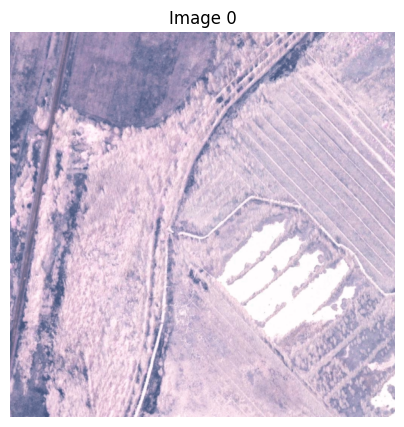

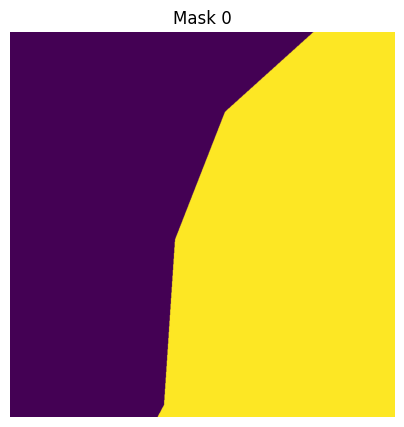

Image 0 shape: (1024, 1024), Mask 0 unique values: [0. 1.]


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


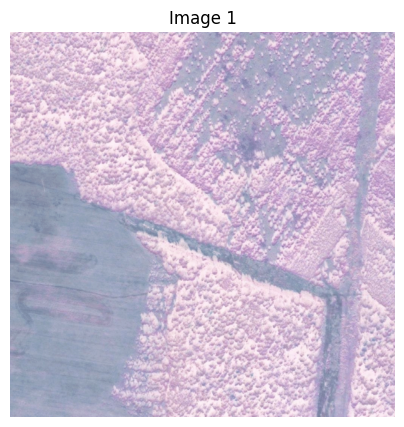

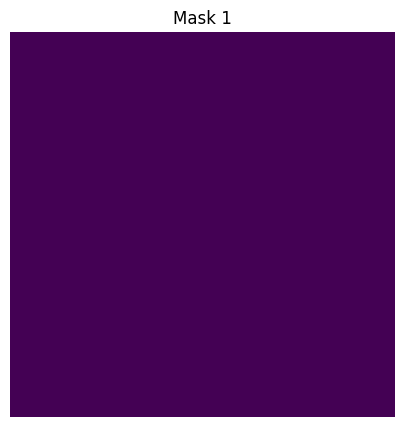

Image 1 shape: (1024, 1024), Mask 1 unique values: [0.]


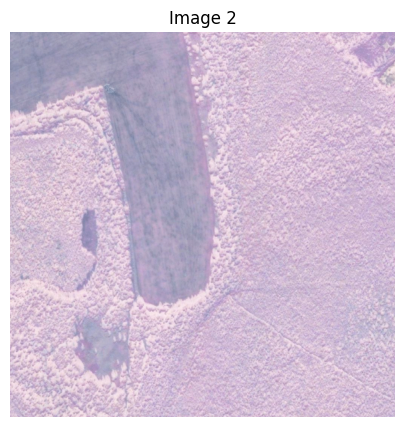

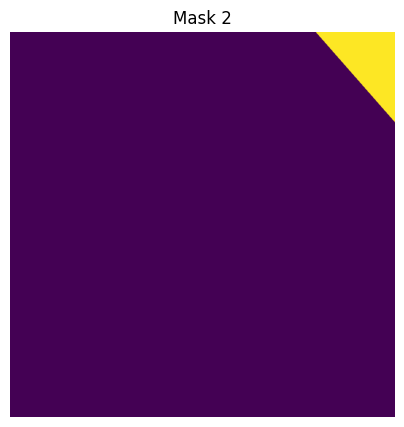

Image 2 shape: (1024, 1024), Mask 2 unique values: [0. 1.]


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

Analyzing masks:   0%|          | 0/1100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

Mean pos_ratio: 0.3716, Min: 0.0000, Max: 1.0000
Proportion of fully negative masks: 0.4291


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Analyzing masks:   0%|          | 0/275 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

Mean pos_ratio: 0.6693, Min: 0.0000, Max: 1.0000
Proportion of fully negative masks: 0.1491


In [8]:
# @title Класс датасета для исследования
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
import rasterio

def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Читаем RGB каналы
        image = np.transpose(image, (1, 2, 0))  # Переводим в HWC
        image = Image.fromarray((image * 255).astype(np.uint8))
    return image

def visualize_image(image, title="Image"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

class ExplorationDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".png") and f.startswith("uid")]
        self.mask_files = {f.replace("_mask_", "_image_").replace(".png", ".png"): f for f in os.listdir(mask_dir) if f.endswith(".png") and f.startswith("uid")}
        self.files = [f for f in self.img_files if f in self.mask_files]

        if not self.files:
            raise ValueError(f"Нет пар изображений и масок в {img_dir} и {mask_dir}. Проверьте пути.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        mask_name = self.mask_files[img_name]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        try:
            image = load_image(img_path)
            mask = np.array(Image.open(mask_path).convert("L")).astype("float32")
        except Exception as e:
            print(f"Ошибка при загрузке {img_path} или {mask_path}: {e}")
            raise
        return image, mask

# @title Анализ данных
PATCHES_DIR = "/content/patchesbigbig/patchesbig"  # Убедитесь, что путь корректен
print(f"Содержимое {PATCHES_DIR}/train/images: {os.listdir(f'{PATCHES_DIR}/train/images')[:5]}...")  # Первые 5 файлов
print(f"Содержимое {PATCHES_DIR}/train/masks: {os.listdir(f'{PATCHES_DIR}/train/masks')[:5]}...")  # Первые 5 файлов
train_ds = ExplorationDataset(f"{PATCHES_DIR}/train/images", f"{PATCHES_DIR}/train/masks")
val_ds = ExplorationDataset(f"{PATCHES_DIR}/val/images", f"{PATCHES_DIR}/val/masks")

# Пример визуализации первых трёх изображений и масок
print(f"Количество файлов в train_ds: {len(train_ds)}")
for i, (image, mask) in enumerate(train_ds):
    if i < 3:
        visualize_image(image, f"Image {i}")
        visualize_image(mask, f"Mask {i}")
        print(f"Image {i} shape: {image.size}, Mask {i} unique values: {np.unique(mask)}")
        if np.max(mask) > 1 or np.min(mask) < 0:
            print(f"Mask {i} needs normalization to [0, 1]")

# @title Статистика масок
def analyze_masks(dataset):
    pos_ratios = []
    for _, mask in tqdm(dataset, desc="Analyzing masks"):
        pos_ratio = np.mean(mask) / 255.0 if mask.max() > 1 else np.mean(mask)
        pos_ratios.append(pos_ratio)
    if not pos_ratios:
        print("Ошибка: Датасет пуст. Проверьте пути к данным или содержимое датасета.")
        return
    print(f"Mean pos_ratio: {np.mean(pos_ratios):.4f}, Min: {np.min(pos_ratios):.4f}, Max: {np.max(pos_ratios):.4f}")
    print(f"Proportion of fully negative masks: {(np.array(pos_ratios) == 0).mean():.4f}")

analyze_masks(train_ds)
analyze_masks(val_ds)